In [6]:
import sqlite3

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import math
import time

#!pip install deepface
from deepface import DeepFace
from deepface.commons import package_utils, folder_utils

In [2]:
model = DeepFace.build_model("Facenet")

In [47]:
facial_img_paths = []
#Available at: https://github.com/serengil/deepface/tree/master/tests/dataset
for root, directory, files in os.walk("../dataset"):
    for file in files:
        if '.jpg' in file:
            facial_img_paths.append(root+"/"+file)

In [48]:
len(facial_img_paths)

62

In [ ]:
instances = []

for i in tqdm(range(0, len(facial_img_paths))):
    facial_img_path = facial_img_paths[i]
    
    #detect and align
    facial_img = DeepFace.extract_faces(facial_img_path, target_size = (160, 160), enforce_detection=False)
    
    #represent
    #embedding = model.predict(facial_img)[0]
    embedding = model.find_embeddings(facial_img)[0].tolist()
    #store
    instance = []
    instance.append(facial_img_path)
    instance.append(embedding)
    instances.append(instance)

In [51]:
instances = []
 
for i in tqdm(range(0, len(facial_img_paths))):
    facial_img_path = facial_img_paths[i]   
    embedding = DeepFace.represent(img_path = facial_img_path, model_name = "Facenet", enforce_detection=False)[0]["embedding"]
     
    instance = []
    instance.append(facial_img_path)
    instance.append(embedding)
    instances.append(instance)

100%|██████████| 62/62 [00:57<00:00,  1.09it/s]


In [60]:
df = pd.DataFrame(instances, columns = ["img_name", "embedding"])
df.head()

,img_name,embedding
0,../dataset/couple.jpg,"[-0.9569708108901978, 0.10792163014411926, -1...."
1,../dataset/img1.jpg,"[0.8597482442855835, 0.9605178833007812, 1.345..."
2,../dataset/img10.jpg,"[-0.3334352374076843, 1.2074142694473267, 1.05..."
3,../dataset/img11.jpg,"[0.4563964009284973, 0.19060522317886353, 1.72..."
4,../dataset/img11_reflection.jpg,"[0.7846647500991821, 0.7575387954711914, 1.717..."


In [62]:
conn = sqlite3.connect('facialdb.db')

In [63]:
cursor = conn.cursor()

In [64]:
cursor.execute('''drop table if exists face_meta ''')
cursor.execute('''drop table if exists face_embeddings''')

cursor.execute('''create table face_meta (ID INT primary key, IMG_NAME VARCHAR(10), EMBEDDING BLOB)''')
cursor.execute('''create table face_embeddings (FACE_ID INT, DIMENSION INT, VALUE DECIMAL(5, 30))''')

In [125]:
import json
import pickle

for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
    img_name = instance["img_name"]
    embeddings = instance["embedding"]
    
    # Convert embeddings to JSON string
    #embeddings_json = json.dumps(embeddings)
    
    # Insert into face_meta table
    insert_statement = "INSERT INTO face_meta (ID, IMG_NAME, EMBEDDING) VALUES (?, ?, ?)"
    insert_args = (index, img_name, pickle.dumps(embeddings))
    cursor.execute(insert_statement, insert_args)
    
    # Insert into face_embeddings table
    for i, embedding in enumerate(embeddings):
        insert_statement = "INSERT INTO face_embeddings (FACE_ID, DIMENSION, VALUE) VALUES (?, ?, ?)"
        insert_args = (index, i, embedding)
        cursor.execute(insert_statement, insert_args)

  0%|          | 0/62 [00:00<?, ?it/s]


IntegrityError: UNIQUE constraint failed: face_meta.ID

In [123]:
import pickle

my_list = [1, 2, 3, 4, 5]
bytes_data = pickle.dumps(my_list)
bytes_data

b'\x80\x04\x95\x0f\x00\x00\x00\x00\x00\x00\x00]\x94(K\x01K\x02K\x03K\x04K\x05e.'

In [74]:
conn.commit()

In [83]:
target_img_path = "../dataset/img27.jpg"

In [109]:
target_img = DeepFace.extract_faces(target_img_path, target_size = (160, 160))[0]["face"]

In [110]:
target_img.shape

(160, 160, 3)

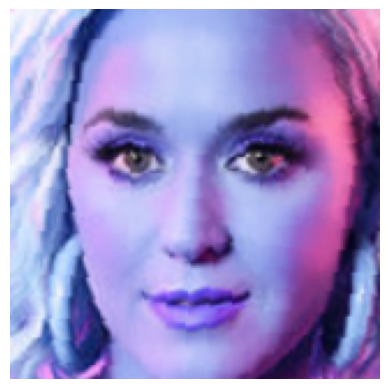

In [112]:
plt.imshow(target_img[:,:,::-1])
plt.axis('off')
plt.show()

In [113]:
target_embedding = DeepFace.represent(img_path = target_img_path, model_name = "Facenet")[0]["embedding"]

In [117]:
target_embedding

[-0.1784716248512268,
 -0.2629108428955078,
 0.40506041049957275,
 -0.7904022932052612,
 0.7101778388023376,
 -0.4073629677295685,
 0.2429463118314743,
 1.220481038093567,
 -1.0822839736938477,
 1.2780824899673462,
 -1.0067836046218872,
 -0.07117477804422379,
 -0.9661664962768555,
 2.069237470626831,
 0.4798787534236908,
 -0.26538386940956116,
 -0.5058234930038452,
 -1.1297475099563599,
 -0.12667693197727203,
 -0.4176056981086731,
 -1.1253255605697632,
 -0.36560872197151184,
 1.7830233573913574,
 -1.4602731466293335,
 0.37899547815322876,
 0.9529144763946533,
 1.3409191370010376,
 -0.6759229898452759,
 -0.2767649292945862,
 -0.6567559242248535,
 0.5995670557022095,
 -1.4579592943191528,
 0.22246596217155457,
 -1.8674067258834839,
 0.33815711736679077,
 0.3648664653301239,
 1.648633599281311,
 0.13778066635131836,
 0.321417897939682,
 -0.6682932376861572,
 -2.6005876064300537,
 -0.44551950693130493,
 0.6452312469482422,
 0.301514208316803,
 1.5219011306762695,
 0.04242589324712753,
 -1.

In [118]:
tic = time.time()

select_statement = "select img_name, embedding from face_meta"
results = cursor.execute(select_statement)

instances = []
for result in results:
    img_name = result[0]
    embedding_bytes = result[1]
    embedding = np.frombuffer(embedding_bytes, dtype = 'float32')
    
    instance = []
    instance.append(img_name)
    instance.append(embedding)
    instances.append(instance)

toc = time.time()
print(toc-tic,"seconds")

TypeError: a bytes-like object is required, not 'str'